In [127]:
# --- Import needed libraries ---
import pandas as pd
import numpy as np
import os
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, root_mean_squared_error, classification_report, log_loss
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from xgboost import XGBClassifier
from datetime import datetime

In [128]:
# --- Configuration ---
DATA_DIR = "dataset"
SEASONS = ["18_19", "19_20", "20_21", "21_22", "22_23", "23_24"]
LEAGUES = ["E0", "F1", "D1", "I1", "SP1"]  # EPL, Ligue 1, Bundesliga, Serie A, La Liga

In [129]:
# --- Load Data ---
def load_all_data():
    all_data = []
    for season in SEASONS:
        for league in LEAGUES:
            # Search recursively for matching files
            pattern = os.path.join(DATA_DIR, '**', f"{league}_{season}.csv")
            for path in glob(pattern, recursive=True):
                df = pd.read_csv(path)
                df['Season'] = season
                df['League'] = league
                all_data.append(df)
    return pd.concat(all_data, ignore_index=True)


--- RAW DATA INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Columns: 126 entries, Div to AvgCAHA
dtypes: float64(100), int64(16), object(10)
memory usage: 10.4+ MB
None

--- RAW DATA HEAD ---
  Div        Date      HomeTeam        AwayTeam  FTHG  FTAG FTR  HTHG  HTAG  \
0  E0  10/08/2018    Man United       Leicester     2     1   H     1     0   
1  E0  11/08/2018   Bournemouth         Cardiff     2     0   H     1     0   
2  E0  11/08/2018        Fulham  Crystal Palace     0     2   A     0     1   
3  E0  11/08/2018  Huddersfield         Chelsea     0     3   A     0     2   
4  E0  11/08/2018     Newcastle       Tottenham     1     2   A     1     2   

  HTR  ... AvgC<2.5  AHCh  B365CAHH  B365CAHA  PCAHH  PCAHA  MaxCAHH  MaxCAHA  \
0   H  ...      NaN   NaN       NaN       NaN    NaN    NaN      NaN      NaN   
1   H  ...      NaN   NaN       NaN       NaN    NaN    NaN      NaN      NaN   
2   A  ...      NaN   NaN       NaN       NaN    Na

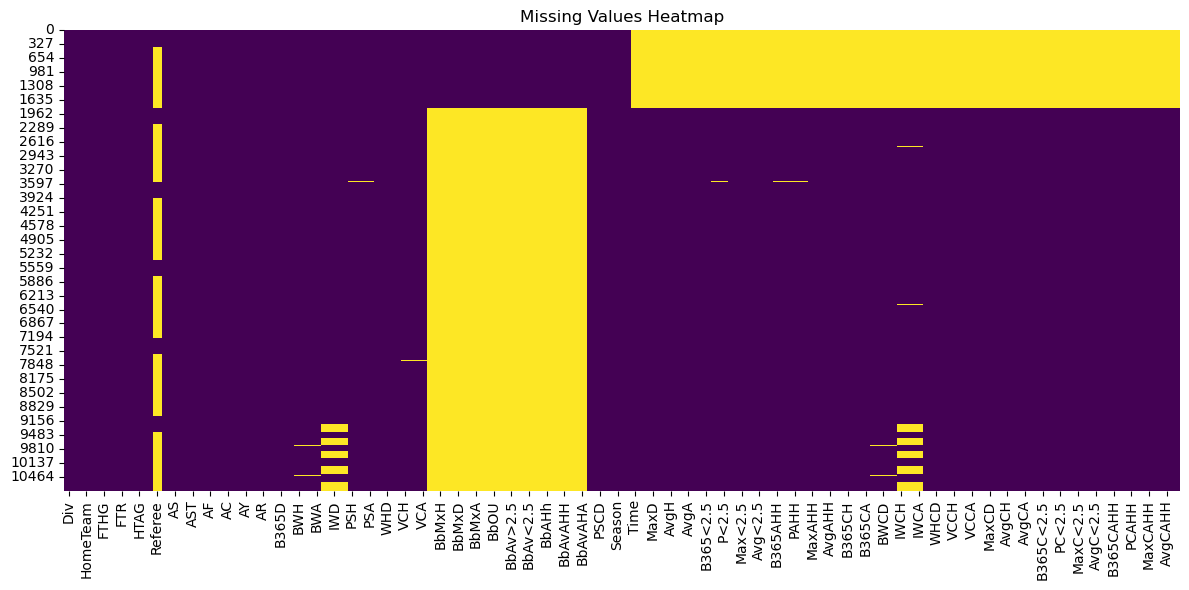

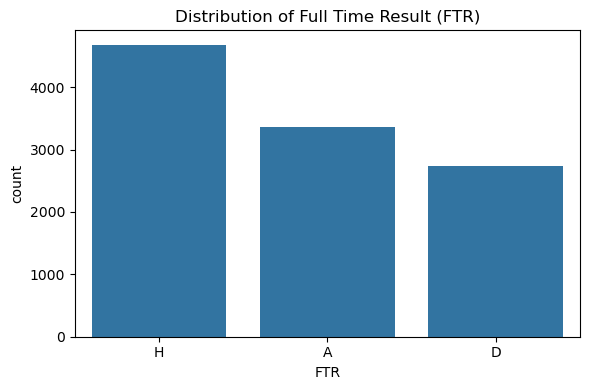

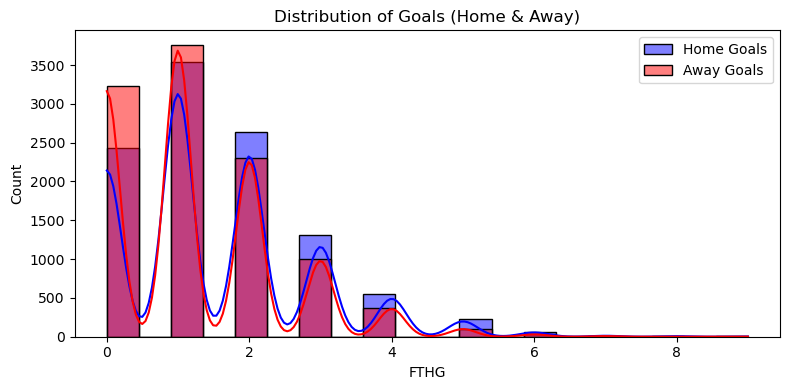

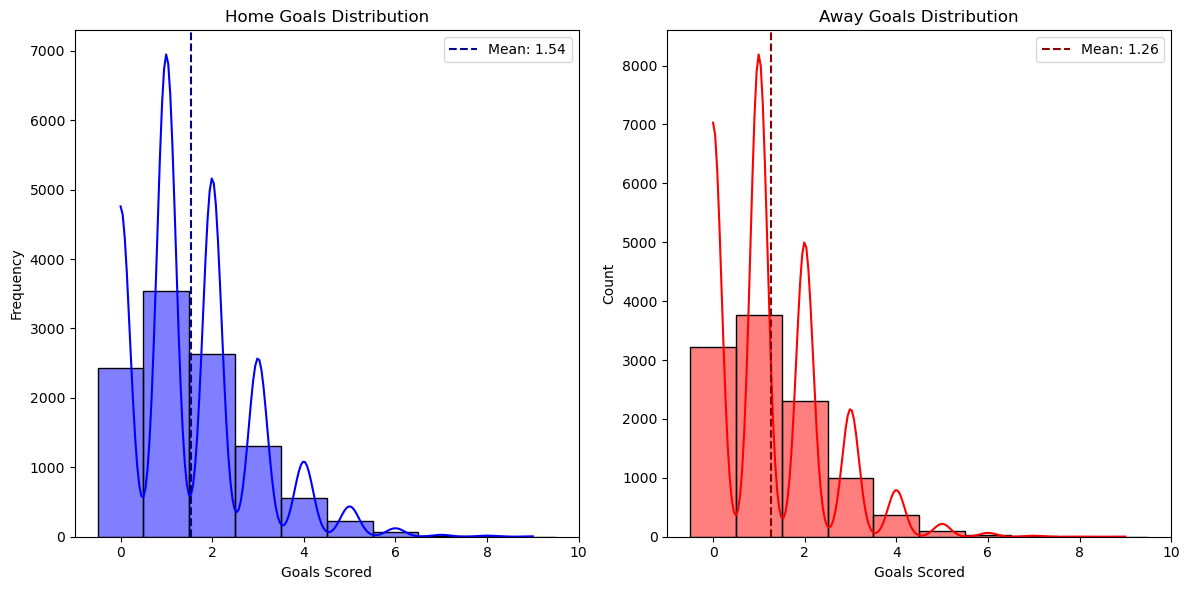


Goal Statistics:
Average home goals: 1.54
Average away goals: 1.26
Most common home goals: 1
Most common away goals: 1
Home goals std. dev: 1.30
Away goals std. dev: 1.17


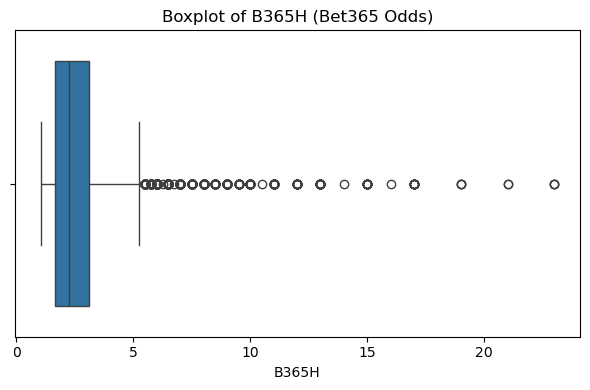

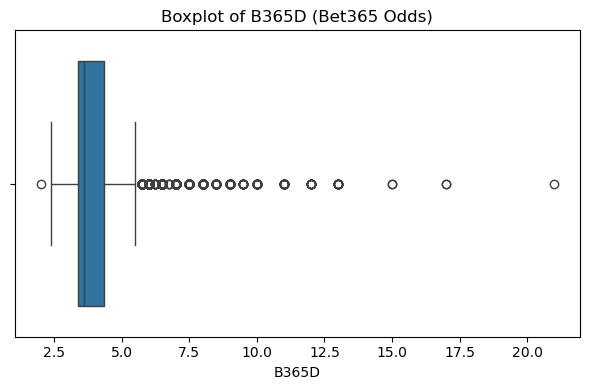

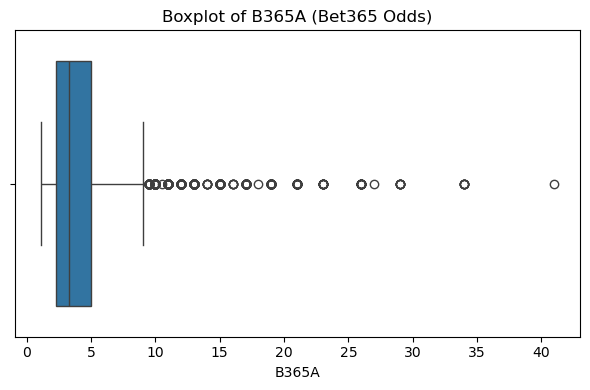

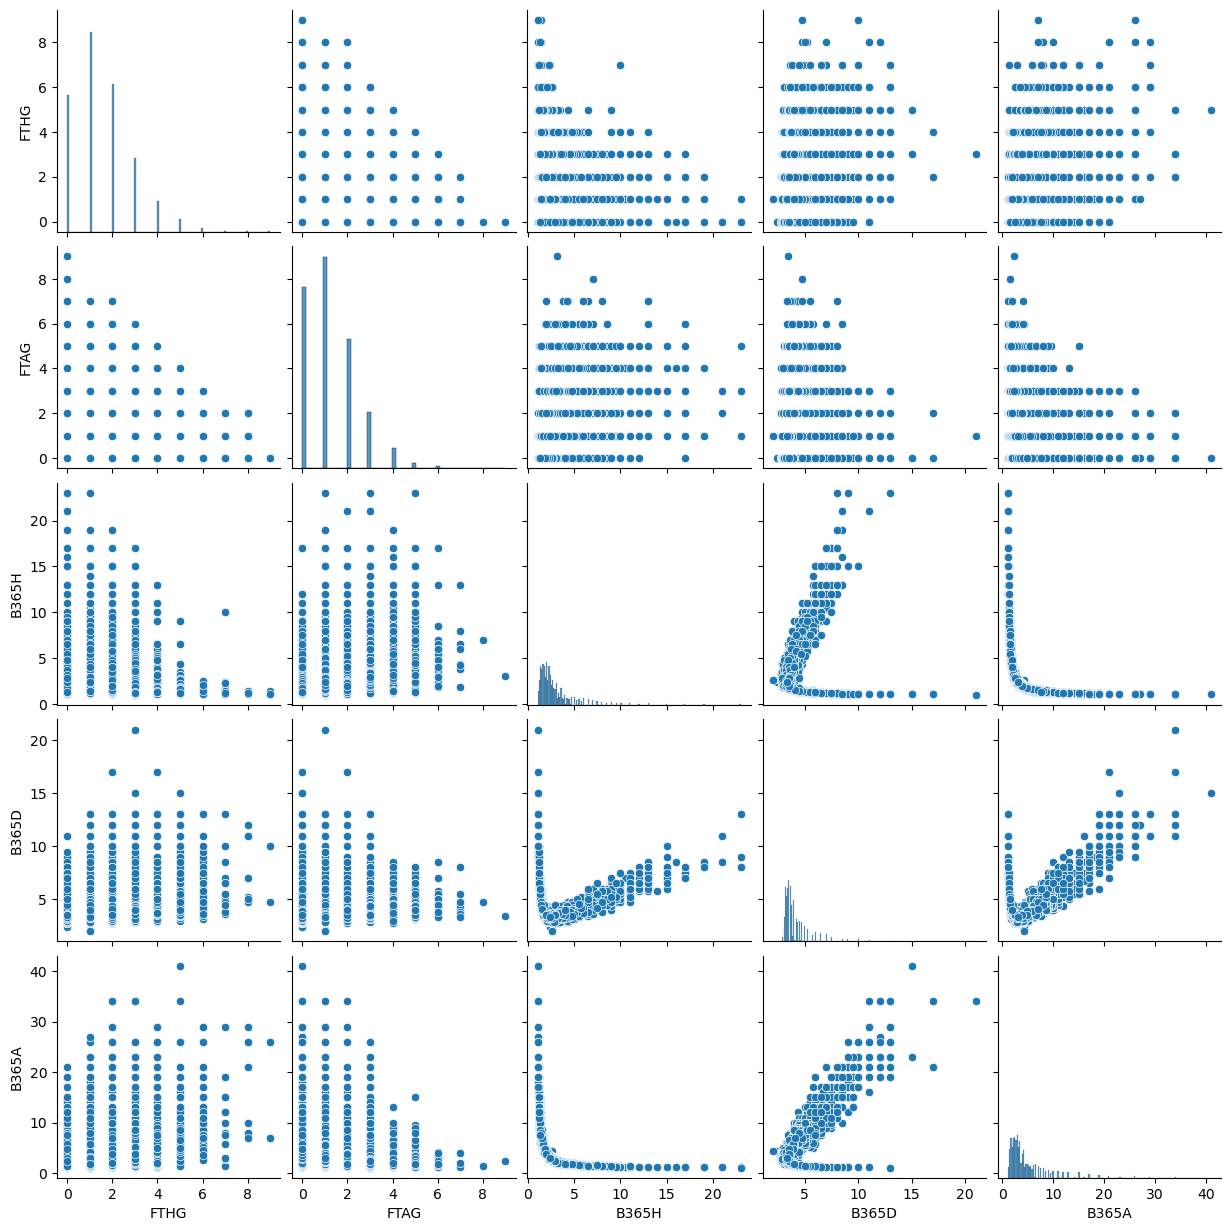

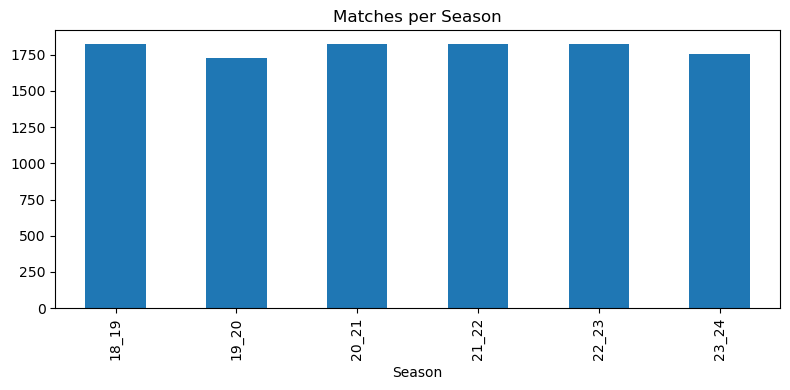

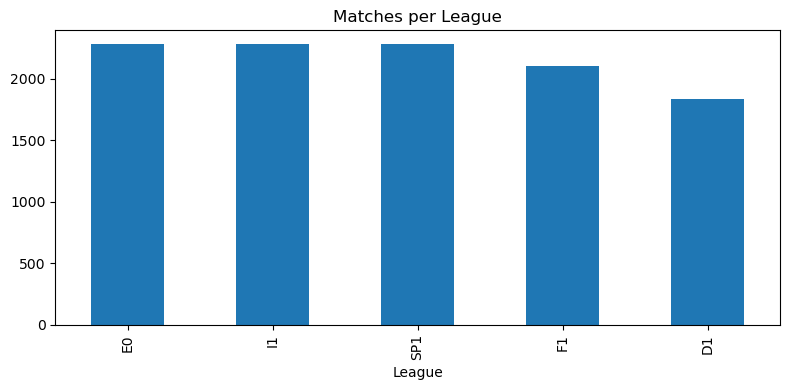

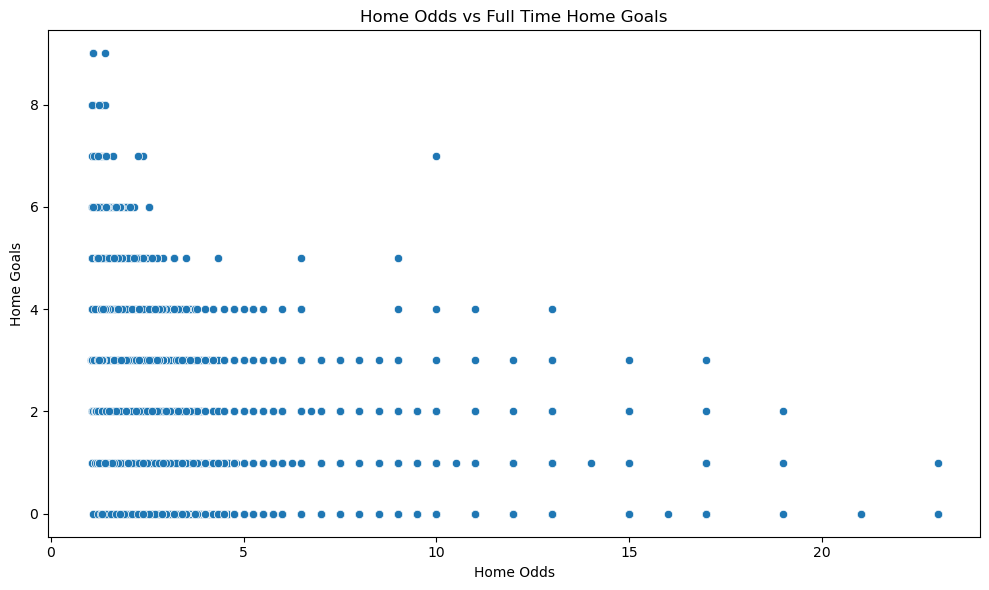

EDA outputs saved to 'outputs/' folder.


In [130]:
# --- Exploratory Data Analysis (EDA) ---

def eda(df):
    print("\n--- RAW DATA INFO ---")
    print(df.info())
    print("\n--- RAW DATA HEAD ---")
    print(df.head())
    print("\n--- RAW DATA DESCRIBE ---")
    print(df.describe(include='all'))

    # Save outputs
    os.makedirs("outputs", exist_ok=True)
    df.describe(include='all').to_csv("outputs/eda_raw_describe.csv")

    # Missing values heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.tight_layout()
    plt.savefig("outputs/eda_missing_heatmap.png")
    plt.show()

    # Distribution of target variable (FTR)
    if 'FTR' in df.columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(x='FTR', data=df)
        plt.title('Distribution of Full Time Result (FTR)')
        plt.tight_layout()
        plt.savefig("outputs/eda_ftr_distribution.png")
        plt.show()

    # Distribution of goals
    if 'FTHG' in df.columns and 'FTAG' in df.columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(df['FTHG'], bins=20, kde=True, color='blue', label='Home Goals')
        sns.histplot(df['FTAG'], bins=20, kde=True, color='red', label='Away Goals')
        plt.legend()
        plt.title('Distribution of Goals (Home & Away)')
        plt.tight_layout()
        plt.savefig("outputs/eda_goals_distribution.png")
        plt.show()

     # Distribution of goals alternative
    if 'FTHG' in df.columns and 'FTAG' in df.columns:
        plt.figure(figsize=(12, 6))
    
        # Create subplots
        plt.subplot(1, 2, 1)
        sns.histplot(df['FTHG'], bins=range(0, df['FTHG'].max()+2), 
                 kde=True, color='blue', discrete=True)
        plt.title('Home Goals Distribution')
        plt.xlabel('Goals Scored')
        plt.ylabel('Frequency')
    
        # Add mean line for home goals
        mean_home = df['FTHG'].mean()
        plt.axvline(mean_home, color='darkblue', linestyle='--', 
                label=f'Mean: {mean_home:.2f}')
        plt.legend()
    
        plt.subplot(1, 2, 2)
        sns.histplot(df['FTAG'], bins=range(0, df['FTAG'].max()+2), 
                 kde=True, color='red', discrete=True)
        plt.title('Away Goals Distribution')
        plt.xlabel('Goals Scored')
    
        # Add mean line for away goals
        mean_away = df['FTAG'].mean()
        plt.axvline(mean_away, color='darkred', linestyle='--', 
                label=f'Mean: {mean_away:.2f}')
        plt.legend()
    
        plt.tight_layout()
    
        # Save and show
        plt.savefig("outputs/eda_goals_distribution.png", dpi=300, bbox_inches='tight')
        plt.show()
    
    # Additional statistics
    print("\nGoal Statistics:")
    print(f"Average home goals: {mean_home:.2f}")
    print(f"Average away goals: {mean_away:.2f}")
    print(f"Most common home goals: {df['FTHG'].mode()[0]}")
    print(f"Most common away goals: {df['FTAG'].mode()[0]}")
    print(f"Home goals std. dev: {df['FTHG'].std():.2f}")
    print(f"Away goals std. dev: {df['FTAG'].std():.2f}")

    # Boxplots for odds
    for col in ['B365H', 'B365D', 'B365A']:
        if col in df.columns:
            plt.figure(figsize=(6, 4))
            sns.boxplot(x=df[col])
            plt.title(f'Boxplot of {col} (Bet365 Odds)')
            plt.tight_layout()
            plt.savefig(f"outputs/eda_boxplot_{col}.png")
            plt.show()

    # Pairplot for selected features 
    selected = ['FTHG', 'FTAG', 'B365H', 'B365D', 'B365A']
    selected = [col for col in selected if col in df.columns]
    if len(selected) > 1:
        sns.pairplot(df[selected].dropna())
        plt.savefig("outputs/eda_pairplot.png")
        plt.show()


    # Season and league distribution
    if 'Season' in df.columns:
        plt.figure(figsize=(8, 4))
        df['Season'].value_counts().sort_index().plot(kind='bar')
        plt.title('Matches per Season')
        plt.tight_layout()
        plt.savefig("outputs/eda_season_distribution.png")
        plt.show()
    if 'League' in df.columns:
        plt.figure(figsize=(8, 4))
        df['League'].value_counts().plot(kind='bar')
        plt.title('Matches per League')
        plt.tight_layout()
        plt.savefig("outputs/eda_league_distribution.png")
        plt.show()


    # Scatter plot of odds vs. goals
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='B365H', y='FTHG', data=df)
    plt.title('Home Odds vs Full Time Home Goals')
    plt.xlabel('Home Odds')
    plt.ylabel('Home Goals')
    plt.tight_layout()
    plt.savefig("outputs/scatter_odds_vs_goals.png")
    plt.show()

    
    print("EDA outputs saved to 'outputs/' folder.")

# --- Load raw data and run deep EDA ---
raw_df = load_all_data()
eda(raw_df)

In [131]:
# --- Feature Engineering for Team Form ---
def add_team_form_features(df, n_matches=6):
    # Sort chronologically for all leagues and seasons
    df = df.sort_values(['Season', 'League', 'Date']).reset_index(drop=True)
    # Prepare columns
    df['HomeTeam_FormPts'] = np.nan
    df['AwayTeam_FormPts'] = np.nan
    df['HomeTeam_FormGS'] = np.nan
    df['AwayTeam_FormGS'] = np.nan
    df['HomeTeam_FormGC'] = np.nan
    df['AwayTeam_FormGC'] = np.nan

    # Store past matches for each team
    team_histories = {}

    for idx, row in df.iterrows():
        home = row['HomeTeam']
        away = row['AwayTeam']

        # Get past matches for each team
        home_hist = team_histories.get(home, [])
        away_hist = team_histories.get(away, [])

        # Calculate rolling stats for home team
        if home_hist:
            last_n = pd.DataFrame(home_hist[-n_matches:])
            df.at[idx, 'HomeTeam_FormPts'] = last_n['points'].mean()
            df.at[idx, 'HomeTeam_FormGS'] = last_n['goals_scored'].mean()
            df.at[idx, 'HomeTeam_FormGC'] = last_n['goals_conceded'].mean()
        # Calculate rolling stats for away team
        if away_hist:
            last_n = pd.DataFrame(away_hist[-n_matches:])
            df.at[idx, 'AwayTeam_FormPts'] = last_n['points'].mean()
            df.at[idx, 'AwayTeam_FormGS'] = last_n['goals_scored'].mean()
            df.at[idx, 'AwayTeam_FormGC'] = last_n['goals_conceded'].mean()

        # Update team histories with current match
        # Home team
        home_points = 3 if row['FTR'] == 'H' else 1 if row['FTR'] == 'D' else 0
        home_gs = row['FTHG']
        home_gc = row['FTAG']
        team_histories.setdefault(home, []).append({
            'points': home_points,
            'goals_scored': home_gs,
            'goals_conceded': home_gc
        })
        # Away team
        away_points = 3 if row['FTR'] == 'A' else 1 if row['FTR'] == 'D' else 0
        away_gs = row['FTAG']
        away_gc = row['FTHG']
        team_histories.setdefault(away, []).append({
            'points': away_points,
            'goals_scored': away_gs,
            'goals_conceded': away_gc
        })

    return df

In [132]:
def add_goal_superiority_feature(df, n_matches=6):
    # Ensure chronological order
    if 'Date' in df.columns:
        df = df.sort_values(['Season', 'League', 'Date']).reset_index(drop=True)
    else:
        df = df.sort_values(['Season', 'League']).reset_index(drop=True)

    # Prepare columns
    df['Home_GoalSup'] = np.nan
    df['Away_GoalSup'] = np.nan
    df['Match_GoalSup'] = np.nan

    # Store past matches for each team
    team_histories = {}

    for idx, row in df.iterrows():
        home = row['HomeTeam']
        away = row['AwayTeam']

        # Get past matches for each team
        home_hist = team_histories.get(home, [])
        away_hist = team_histories.get(away, [])

        # Calculate rolling goal superiority for home team
        if home_hist:
            last_n = pd.DataFrame(home_hist[-n_matches:])
            gs = last_n['goals_scored'].sum()
            gc = last_n['goals_conceded'].sum()
            df.at[idx, 'Home_GoalSup'] = gs - gc
        # Calculate rolling goal superiority for away team
        if away_hist:
            last_n = pd.DataFrame(away_hist[-n_matches:])
            gs = last_n['goals_scored'].sum()
            gc = last_n['goals_conceded'].sum()
            df.at[idx, 'Away_GoalSup'] = gs - gc

        # Update team histories with current match
        # Home team
        home_gs = row['FTHG']
        home_gc = row['FTAG']
        team_histories.setdefault(home, []).append({
            'goals_scored': home_gs,
            'goals_conceded': home_gc
        })
        # Away team
        away_gs = row['FTAG']
        away_gc = row['FTHG']
        team_histories.setdefault(away, []).append({
            'goals_scored': away_gs,
            'goals_conceded': away_gc
        })

    # Calculate match goal superiority
    df['Match_GoalSup'] = df['Home_GoalSup'] - df['Away_GoalSup']
    return df

In [133]:
# --- Feature Engineering ---
def engineer_features(df):
    df = df.dropna(subset=['FTR', 'HomeTeam', 'AwayTeam'])
    df = add_team_form_features(df)
    df = add_goal_superiority_feature(df, n_matches=6)
    # Convert 'Date' to numeric (ordinal) if present
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
        df['Date'] = df['Date'].map(lambda x: x.toordinal() if pd.notnull(x) else np.nan)
    # Add new features to the selected columns
    feature_cols = [
        'Date',
        'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
        'B365H', 'B365D', 'B365A', 'Season', 'League',
        'HomeTeam_FormPts', 'AwayTeam_FormPts',
        'HomeTeam_FormGS', 'AwayTeam_FormGS',
        'HomeTeam_FormGC', 'AwayTeam_FormGC',
        'Home_GoalSup', 'Away_GoalSup', 'Match_GoalSup' 
    ]
    # Only keep columns that exist in the dataframe
    feature_cols = [col for col in feature_cols if col in df.columns]
    df = df[feature_cols]

    # Implied Probabilities
    df['Imp_H'] = 1 / df['B365H']
    df['Imp_D'] = 1 / df['B365D']
    df['Imp_A'] = 1 / df['B365A']
    
    # Normalize to sum to 1
    total = df[['Imp_H', 'Imp_D', 'Imp_A']].sum(axis=1)
    df['Imp_H'] /= total
    df['Imp_D'] /= total
    df['Imp_A'] /= total

    # Encode result
    df['Result'] = df['FTR'].map({'H': 0, 'D': 1, 'A': 2})

    # Encode teams
    le = LabelEncoder()
    df['HomeTeam'] = le.fit_transform(df['HomeTeam'])
    home_team_encoder = le  # Save encoder for later use
    le2 = LabelEncoder()
    df['AwayTeam'] = le2.fit_transform(df['AwayTeam'])
    away_team_encoder = le2  # Save encoder for later use

    # Encode League and Season
    df['League'] = LabelEncoder().fit_transform(df['League'])
    df['Season'] = LabelEncoder().fit_transform(df['Season'])

    return df.dropna(), home_team_encoder, away_team_encoder

In [134]:
# --- Correlation Matrix ---
def correlation_matrix(df):
    corr_cols = [
        'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'Imp_H', 'Imp_D', 'Imp_A', 'Result',
        'HomeTeam_FormPts', 'AwayTeam_FormPts',
        'HomeTeam_FormGS', 'AwayTeam_FormGS',
        'HomeTeam_FormGC', 'AwayTeam_FormGC',
        'Home_GoalSup', 'Away_GoalSup', 'Match_GoalSup'
    ]

    # Correlation matrix
    plt.figure(figsize=(10, 6))
    corr_cols = [col for col in corr_cols if col in df.columns]
    corr = df[corr_cols].corr()
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig("outputs/correlation_matrix.png")
    plt.show()

    # Save correlation matrix to outputs folder
    corr.to_csv("outputs/eda_correlations.csv")

<Figure size 1000x600 with 0 Axes>

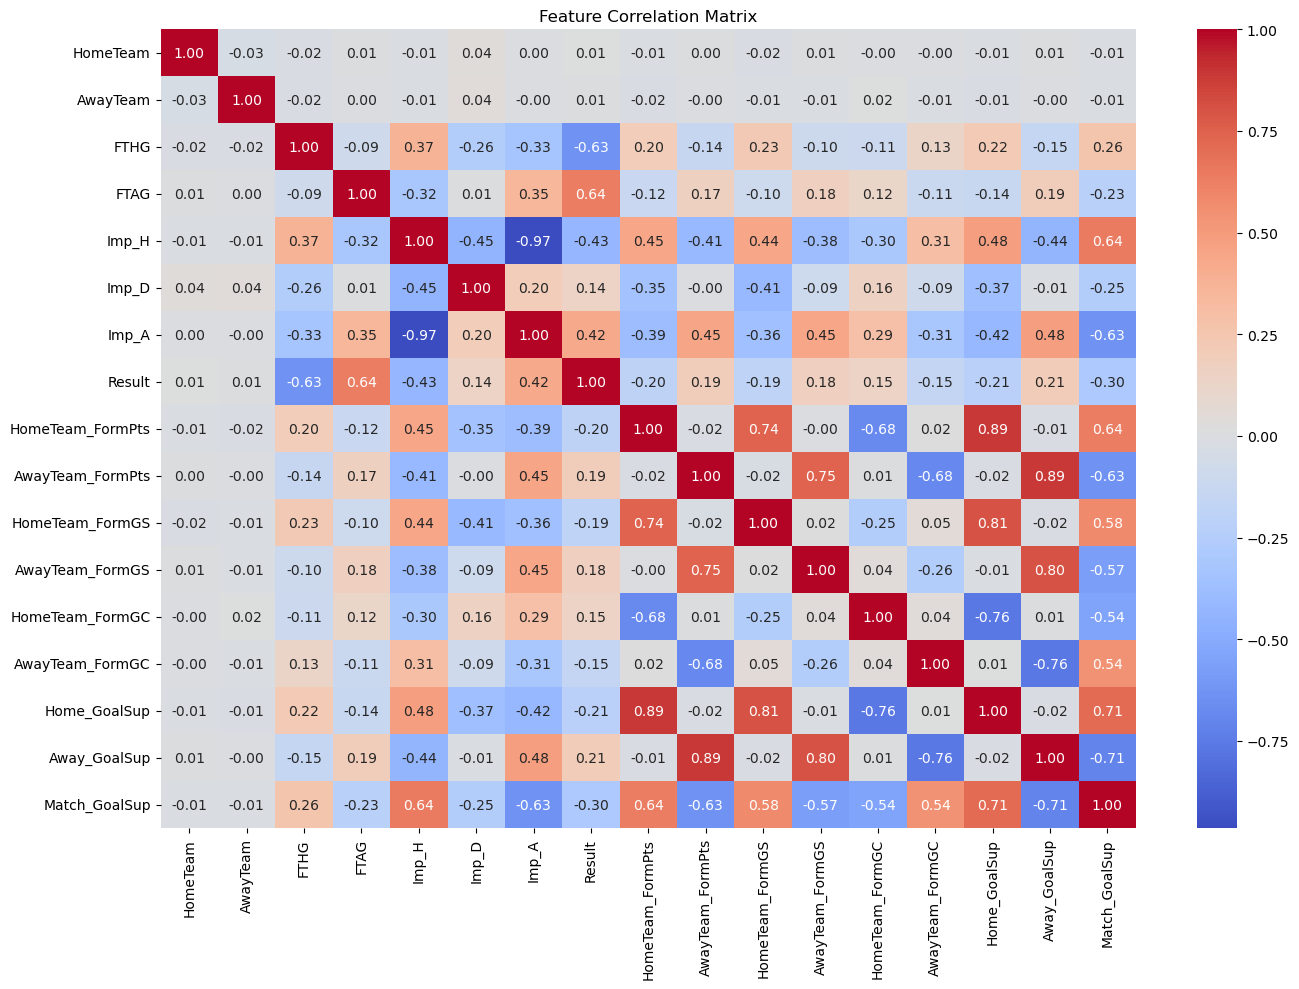

In [135]:
df = load_all_data()
df, home_team_encoder, away_team_encoder = engineer_features(df)
correlation_matrix(df)

In [136]:
# --- Split Train/Test ---
def split_data(df):
    test_season = df['Season'].max()
    train_df = df[df['Season'] < test_season]
    test_df = df[df['Season'] == test_season]
    X_train = train_df.drop(columns=['FTR', 'FTHG', 'FTAG', 'Result'])
    y_train = train_df['Result']
    X_test = test_df.drop(columns=['FTR', 'FTHG', 'FTAG', 'Result'])
    y_test = test_df['Result']
    return X_train, X_test, y_train, y_test

In [137]:
df = load_all_data()
df, home_team_encoder, away_team_encoder = engineer_features(df)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    df['Date'] = df['Date'].map(lambda x: x.toordinal() if pd.notnull(x) else np.nan)
X_train, X_test, y_train, y_test = split_data(df)

print("Features used for training:", X_train.columns.tolist())
print("Features used for testing:", X_test.columns.tolist())

Features used for training: ['Date', 'HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A', 'Season', 'League', 'HomeTeam_FormPts', 'AwayTeam_FormPts', 'HomeTeam_FormGS', 'AwayTeam_FormGS', 'HomeTeam_FormGC', 'AwayTeam_FormGC', 'Home_GoalSup', 'Away_GoalSup', 'Match_GoalSup', 'Imp_H', 'Imp_D', 'Imp_A']
Features used for testing: ['Date', 'HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A', 'Season', 'League', 'HomeTeam_FormPts', 'AwayTeam_FormPts', 'HomeTeam_FormGS', 'AwayTeam_FormGS', 'HomeTeam_FormGC', 'AwayTeam_FormGC', 'Home_GoalSup', 'Away_GoalSup', 'Match_GoalSup', 'Imp_H', 'Imp_D', 'Imp_A']


In [138]:
# --- Model Training and Evaluation with Cross-Validation and Hyperparameter Tuning ---
def train_and_evaluate(X_train, X_test, y_train, y_test):
    results = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    model_params = {
        'Logistic Regression': {
            'model': LogisticRegression(max_iter=20000),
            'params': {'C': [0.01, 0.1, 1, 10]}
        },
        'Random Forest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {'n_estimators': [100, 300, 1000], 'max_depth': [None, 10, 20]}
        },
        'SVM': {
            'model': SVC(probability=True),
            'params': {'C': [1], 'kernel': ['rbf']}
        },
        'MLP': {
            'model': MLPClassifier(max_iter=500, early_stopping=True, random_state=42),
            'params': {
                'hidden_layer_sizes': [(128, 64), (64, 32)],
                'alpha': [0.0005, 0.001]
            }
        },
        'XGBoost': {
            'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
            'params': {
                'n_estimators': [100, 300],
                'learning_rate': [0.05, 0.1],
                'max_depth': [3, 5]
            }
        }
    }

    for name, mp in model_params.items():
        print(f"\nTuning {name}...")
        grid = GridSearchCV(mp['model'], mp['params'], cv=cv, scoring='neg_log_loss', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        preds = best_model.predict(X_test)
        if hasattr(best_model, "predict_proba"):
            pred_probs = best_model.predict_proba(X_test)
        else:
            pred_probs = best_model.decision_function(X_test)
            pred_probs = np.exp(pred_probs) / np.sum(np.exp(pred_probs), axis=1, keepdims=True)
        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average='macro')
        rmse = np.sqrt(root_mean_squared_error(y_test, preds))
        loss = log_loss(y_test, pred_probs)
        print(f"Best params: {grid.best_params_}")
        print(f"Accuracy: {acc:.2f}, F1 Score: {f1:.2f}, RMSE: {rmse:.2f}, Log Loss: {loss:.2f}")
        print(classification_report(y_test, preds))
        results.append([name, acc, f1, rmse, loss, grid.best_params_])

    # Save results to CSV
    with open("outputs/model_evaluation_cv.csv", "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Model", "Accuracy", "F1 Score", "RMSE", "Log Loss", "Best Params"])
        writer.writerows(results)

In [139]:
# --- Main Pipeline ---
def main():
    df = load_all_data()
    df, home_team_encoder, away_team_encoder = engineer_features(df)
    X_train, X_test, y_train, y_test = split_data(df)
    train_and_evaluate(X_train, X_test, y_train, y_test)

if __name__ == "__main__":
    main()


Tuning Logistic Regression...


c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0

Best params: {'C': 10}
Accuracy: 0.55, F1 Score: 0.41, RMSE: 1.01, Log Loss: 0.96
              precision    recall  f1-score   support

           0       0.54      0.87      0.67       753
           1       0.00      0.00      0.00       462
           2       0.56      0.56      0.56       532

    accuracy                           0.55      1747
   macro avg       0.37      0.48      0.41      1747
weighted avg       0.40      0.55      0.46      1747


Tuning Random Forest...
Best params: {'max_depth': 10, 'n_estimators': 1000}
Accuracy: 0.53, F1 Score: 0.41, RMSE: 1.01, Log Loss: 0.97
              precision    recall  f1-score   support

           0       0.54      0.86      0.66       753
           1       0.21      0.02      0.03       462
           2       0.55      0.53      0.54       532

    accuracy                           0.53      1747
   macro avg       0.43      0.47      0.41      1747
weighted avg       0.45      0.53      0.46      1747


Tuning SVM...
Best

c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best params: {'alpha': 0.0005, 'hidden_layer_sizes': (128, 64)}
Accuracy: 0.43, F1 Score: 0.20, RMSE: 1.10, Log Loss: 20.51
              precision    recall  f1-score   support

           0       0.43      1.00      0.60       753
           1       0.00      0.00      0.00       462
           2       0.00      0.00      0.00       532

    accuracy                           0.43      1747
   macro avg       0.14      0.33      0.20      1747
weighted avg       0.19      0.43      0.26      1747


Tuning XGBoost...


c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\anaconda3\Lib\sit

Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.52, F1 Score: 0.39, RMSE: 1.02, Log Loss: 0.97
              precision    recall  f1-score   support

           0       0.51      0.92      0.65       753
           1       0.17      0.01      0.02       462
           2       0.62      0.40      0.48       532

    accuracy                           0.52      1747
   macro avg       0.43      0.44      0.39      1747
weighted avg       0.45      0.52      0.43      1747



In [140]:
# --- Prepare test_df and test_probs for betting simulation ---

# 1. Load and process data
df = load_all_data()
df, home_team_encoder, away_team_encoder = engineer_features(df)

# 2. Split data
test_season = df['Season'].max()
train_df = df[df['Season'] < test_season]
test_df = df[df['Season'] == test_season]  

X_train = train_df.drop(columns=['FTR', 'FTHG', 'FTAG', 'Result'])
y_train = train_df['Result']
X_test = test_df.drop(columns=['FTR', 'FTHG', 'FTAG', 'Result'])
y_test = test_df['Result']

In [141]:
# --- Train Logistic Regression and get probabilities ---
lr = LogisticRegression(max_iter=1000, C=10)
lr.fit(X_train, y_train)
lr_probs = lr.predict_proba(X_test)  

c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [142]:
# --- Simulate Betting Strategy for LR ---

# Compute fair odds (1/prob) for each outcome
fair_odds = 1 / np.clip(lr_probs, 1e-8, 1)  # avoid division by zero

# Add to test_df for simulation
fair_odds_df = pd.DataFrame(fair_odds, columns=['Fair_H', 'Fair_D', 'Fair_A'])
prob_cols = ['Prob_H', 'Prob_D', 'Prob_A']
probs_df = pd.DataFrame(lr_probs, columns=prob_cols)
sim_df = test_df.reset_index(drop=True).copy()
sim_df = pd.concat([sim_df, probs_df, fair_odds_df], axis=1)

sim_df['HomeTeam_name'] = home_team_encoder.inverse_transform(sim_df['HomeTeam'].astype(int))
sim_df['AwayTeam_name'] = away_team_encoder.inverse_transform(sim_df['AwayTeam'].astype(int))

# Simulate betting: bet if fair odds < B365 odds

bet_results = []
bet_report = []  # Collect details for each bet
stake = 1
num_bets = 0

for idx, row in sim_df.iterrows():
    # Draw
    if row['Fair_D'] < row['B365D']:
        win = 1 if row['Result'] == 1 else 0
        payout = (row['B365D'] * stake) if win else 0
        profit = payout - stake
        bet_results.append(profit)
        num_bets += 1
        bet_report.append({
            'MatchIdx': idx,
            'Date': datetime.fromordinal(int(row['Date'])) if not pd.isnull(row['Date']) else None,
            'League': row['League'] if 'League' in row else None,
            'HomeTeam': row['HomeTeam_name'],
            'AwayTeam': row['AwayTeam_name'],
            'BetType': 'Draw',
            'Odds': row['B365D'],
            'FairOdds': row['Fair_D'],
            'Stake': stake,
            'Result': row['Result'],
            'Win': win,
            'Profit': profit
        })

# Convert to DataFrame for easy viewing and saving
bet_report_lr_df = pd.DataFrame(bet_report)
bet_report_lr_df.to_csv("outputs/bet_report_lr.csv", index=False)
print(bet_report_lr_df.head())


total_return = sum(bet_results)
num_bets = len(bet_results)
avg_return = total_return / num_bets if num_bets > 0 else 0
roi = (total_return / num_bets) * 100 if num_bets > 0 else 0
num_wins = sum(1 for profit in bet_results if profit > 0)
num_losses = sum(1 for profit in bet_results if profit < 0)
hit_rate = num_wins / num_bets if num_bets > 0 else 0
avg_odds = sim_df.loc[[row['Fair_D'] < row['B365D'] for _, row in sim_df.iterrows()], 'B365D'].mean()

print(f"Total return: {total_return:.2f} units")
print(f"Number of bets: {num_bets}")
print(f"Average return per bet: {avg_return:.3f} units")
print(f"ROI: {roi:.2f}%")
print(f"Number of winning bets: {num_wins}")
print(f"Number of losing bets: {num_losses}")
print(f"Hit rate: {hit_rate:.2%}")
print(f"Average odds: {avg_odds:.2f}")

   MatchIdx       Date  League    HomeTeam    AwayTeam BetType  Odds  \
0         1 2023-10-01       0    Freiburg    Augsburg    Draw  4.00   
1         3 2024-02-02       0  Heidenheim    Dortmund    Draw  4.50   
2         5 2024-03-02       0   Darmstadt    Augsburg    Draw  3.30   
3         7 2024-03-02       0       Mainz  M'gladbach    Draw  3.75   
4        10 2023-09-02       0    Augsburg      Bochum    Draw  3.75   

   FairOdds  Stake  Result  Win  Profit  
0  3.741166      1       0    0   -1.00  
1  3.974927      1       1    1    3.50  
2  3.011173      1       2    0   -1.00  
3  3.409642      1       1    1    2.75  
4  3.282028      1       1    1    2.75  
Total return: 65.30 units
Number of bets: 741
Average return per bet: 0.088 units
ROI: 8.81%
Number of winning bets: 212
Number of losing bets: 529
Hit rate: 28.61%
Average odds: 3.96


In [143]:
# --- Train XGBoost and get probabilities ---
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42, n_estimators=100, learning_rate=0.05, max_depth=3)
xgb.fit(X_train, y_train)
calibrated_xgb = CalibratedClassifierCV(xgb, method='isotonic', cv='prefit')
calibrated_xgb.fit(X_train, y_train)
xgb_probs = calibrated_xgb.predict_proba(X_test)

In [144]:
# --- Simulate Betting Strategy for XGBoost ---

# Compute fair odds (1/prob) for each outcome
fair_odds = 1 / np.clip(xgb_probs, 1e-8, 1)  # avoid division by zero

# Add to test_df for simulation
fair_odds_df = pd.DataFrame(fair_odds, columns=['Fair_H', 'Fair_D', 'Fair_A'])
prob_cols = ['Prob_H', 'Prob_D', 'Prob_A']
probs_df = pd.DataFrame(xgb_probs, columns=prob_cols)
sim_df = test_df.reset_index(drop=True).copy()
sim_df = pd.concat([sim_df, probs_df, fair_odds_df], axis=1)

sim_df['HomeTeam_name'] = home_team_encoder.inverse_transform(sim_df['HomeTeam'].astype(int))
sim_df['AwayTeam_name'] = away_team_encoder.inverse_transform(sim_df['AwayTeam'].astype(int))

# Simulate betting: bet if fair odds < B365 odds

bet_results = []
bet_report = []  # Collect details for each bet
stake = 1
num_bets = 0

for idx, row in sim_df.iterrows():
    # Draw
    if row['Fair_D'] < row['B365D']:
        win = 1 if row['Result'] == 1 else 0
        payout = (row['B365D'] * stake) if win else 0
        profit = payout - stake
        bet_results.append(profit)
        num_bets += 1
        bet_report.append({
            'MatchIdx': idx,
            'Date': datetime.fromordinal(int(row['Date'])) if not pd.isnull(row['Date']) else None,
            'League': row['League'] if 'League' in row else None,
            'HomeTeam': row['HomeTeam_name'],
            'AwayTeam': row['AwayTeam_name'],
            'BetType': 'Draw',
            'Odds': row['B365D'],
            'FairOdds': row['Fair_D'],
            'Stake': stake,
            'Result': row['Result'],
            'Win': win,
            'Profit': profit
        })

# Convert to DataFrame for easy viewing and saving
bet_report_xgb_df = pd.DataFrame(bet_report)
bet_report_xgb_df.to_csv("outputs/bet_report_xgb.csv", index=False)
print(bet_report_xgb_df.head())


total_return = sum(bet_results)
num_bets = len(bet_results)
avg_return = total_return / num_bets if num_bets > 0 else 0
roi = (total_return / num_bets) * 100 if num_bets > 0 else 0
num_wins = sum(1 for profit in bet_results if profit > 0)
num_losses = sum(1 for profit in bet_results if profit < 0)
hit_rate = num_wins / num_bets if num_bets > 0 else 0
avg_odds = sim_df.loc[[row['Fair_D'] < row['B365D'] for _, row in sim_df.iterrows()], 'B365D'].mean()

print(f"Total return: {total_return:.2f} units")
print(f"Number of bets: {num_bets}")
print(f"Average return per bet: {avg_return:.3f} units")
print(f"ROI: {roi:.2f}%")
print(f"Number of winning bets: {num_wins}")
print(f"Number of losing bets: {num_losses}")
print(f"Hit rate: {hit_rate:.2%}")
print(f"Average odds: {avg_odds:.2f}")

   MatchIdx       Date  League      HomeTeam       AwayTeam BetType  Odds  \
0         3 2024-02-02       0    Heidenheim       Dortmund    Draw  4.50   
1         5 2024-03-02       0     Darmstadt       Augsburg    Draw  3.30   
2         8 2024-03-02       0  Union Berlin       Dortmund    Draw  3.60   
3         9 2024-03-02       0     Wolfsburg      Stuttgart    Draw  3.50   
4        15 2023-09-02       0    M'gladbach  Bayern Munich    Draw  5.75   

   FairOdds  Stake  Result  Win  Profit  
0  4.179104      1       1    1     3.5  
1  2.478501      1       2    0    -1.0  
2  3.068080      1       2    0    -1.0  
3  3.126545      1       2    0    -1.0  
4  5.084120      1       2    0    -1.0  
Total return: 56.90 units
Number of bets: 482
Average return per bet: 0.118 units
ROI: 11.80%
Number of winning bets: 142
Number of losing bets: 340
Hit rate: 29.46%
Average odds: 4.07


In [145]:
# --- Train Random Forest and get probabilities ---
rf = RandomForestClassifier(n_estimators=1000, max_depth=10)
rf.fit(X_train, y_train)
calibrated_rf = CalibratedClassifierCV(rf, method='isotonic', cv='prefit')
calibrated_rf.fit(X_train, y_train)
rf_probs = calibrated_rf.predict_proba(X_test)

In [146]:
# --- Simulate Betting Strategy for RF ---

# Compute fair odds (1/prob) for each outcome
fair_odds = 1 / np.clip(rf_probs, 1e-8, 1)  # avoid division by zero

# Add to test_df for simulation
fair_odds_df = pd.DataFrame(fair_odds, columns=['Fair_H', 'Fair_D', 'Fair_A'])
prob_cols = ['Prob_H', 'Prob_D', 'Prob_A']
probs_df = pd.DataFrame(rf_probs, columns=prob_cols)
sim_df = test_df.reset_index(drop=True).copy()
sim_df = pd.concat([sim_df, probs_df, fair_odds_df], axis=1)

sim_df['HomeTeam_name'] = home_team_encoder.inverse_transform(sim_df['HomeTeam'].astype(int))
sim_df['AwayTeam_name'] = away_team_encoder.inverse_transform(sim_df['AwayTeam'].astype(int))

# Simulate betting: bet if fair odds < B365 odds

bet_results = []
bet_report = []  # Collect details for each bet
stake = 1
num_bets = 0

for idx, row in sim_df.iterrows():
    # Draw
    if row['Fair_D'] < row['B365D']:
        win = 1 if row['Result'] == 1 else 0
        payout = (row['B365D'] * stake) if win else 0
        profit = payout - stake
        bet_results.append(profit)
        num_bets += 1
        bet_report.append({
            'MatchIdx': idx,
            'Date': datetime.fromordinal(int(row['Date'])) if not pd.isnull(row['Date']) else None,
            'League': row['League'] if 'League' in row else None,
            'HomeTeam': row['HomeTeam_name'],
            'AwayTeam': row['AwayTeam_name'],
            'BetType': 'Draw',
            'Odds': row['B365D'],
            'FairOdds': row['Fair_D'],
            'Stake': stake,
            'Result': row['Result'],
            'Win': win,
            'Profit': profit
        })

# Convert to DataFrame for easy viewing and saving
bet_report_rf_df = pd.DataFrame(bet_report)
bet_report_rf_df.to_csv("outputs/bet_report_rf.csv", index=False)
print(bet_report_rf_df.head())


total_return = sum(bet_results)
num_bets = len(bet_results)
avg_return = total_return / num_bets if num_bets > 0 else 0
roi = (total_return / num_bets) * 100 if num_bets > 0 else 0
num_wins = sum(1 for profit in bet_results if profit > 0)
num_losses = sum(1 for profit in bet_results if profit < 0)
hit_rate = num_wins / num_bets if num_bets > 0 else 0
avg_odds = sim_df.loc[[row['Fair_D'] < row['B365D'] for _, row in sim_df.iterrows()], 'B365D'].mean()

print(f"Total return: {total_return:.2f} units")
print(f"Number of bets: {num_bets}")
print(f"Average return per bet: {avg_return:.3f} units")
print(f"ROI: {roi:.2f}%")
print(f"Number of winning bets: {num_wins}")
print(f"Number of losing bets: {num_losses}")
print(f"Hit rate: {hit_rate:.2%}")
print(f"Average odds: {avg_odds:.2f}")

   MatchIdx       Date  League       HomeTeam       AwayTeam BetType  Odds  \
0         2 2023-12-01       0      Darmstadt        FC Koln    Draw   3.4   
1         3 2024-02-02       0     Heidenheim       Dortmund    Draw   4.5   
2         5 2024-03-02       0      Darmstadt       Augsburg    Draw   3.3   
3         6 2024-03-02       0     Heidenheim  Ein Frankfurt    Draw   3.3   
4        14 2023-09-02       0  Werder Bremen          Mainz    Draw   3.5   

   FairOdds  Stake  Result  Win  Profit  
0  2.416575      1       2    0    -1.0  
1  1.668369      1       1    1     3.5  
2  2.395772      1       2    0    -1.0  
3  1.743868      1       2    0    -1.0  
4  1.872332      1       0    0    -1.0  
Total return: 18.83 units
Number of bets: 427
Average return per bet: 0.044 units
ROI: 4.41%
Number of winning bets: 129
Number of losing bets: 298
Hit rate: 30.21%
Average odds: 3.56


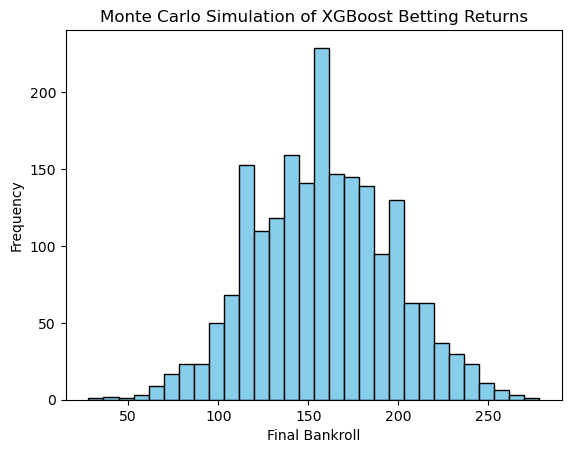

Mean final bankroll: 157.81
Median final bankroll: 156.90
Std dev of final bankroll: 38.17
Best final bankroll: 278.34
Worst final bankroll: 27.87


In [147]:
# --- Monte Carlo Betting Simulation for XGBoost predictions ---
def monte_carlo_betting_simulation(data, num_simulations=2000, bankroll=100, bet_size=1):
    
    # Get win probabilities and odds from data
    win_prob = len(data[data['Win'] == 1]) / len(data)
    avg_odds = data[data['Win'] == 1]['Odds'].mean()
    
    final_bankrolls = []
    
    for _ in range(num_simulations):
        current_bankroll = bankroll
        num_bets = len(data)
        
        # Simulate each bet
        for _ in range(num_bets):
            if current_bankroll <= 0:
                break  # Stop if bankrupt
                
            # Random outcome based on win probability
            if np.random.random() < win_prob:
                current_bankroll += bet_size * (avg_odds - 1)  # Win
            else:
                current_bankroll -= bet_size  # Loss
                
        final_bankrolls.append(current_bankroll)
    
    return np.array(final_bankrolls)

# Run simulation
final_balances = monte_carlo_betting_simulation(bet_report_xgb_df)

# Plot results
plt.hist(final_balances, bins=30, color='skyblue', edgecolor='k')
plt.title('Monte Carlo Simulation of XGBoost Betting Returns')
plt.xlabel('Final Bankroll')
plt.ylabel('Frequency')
plt.show()

print(f"Mean final bankroll: {np.mean(final_balances):.2f}")
print(f"Median final bankroll: {np.median(final_balances):.2f}")
print(f"Std dev of final bankroll: {np.std(final_balances):.2f}")
print(f"Best final bankroll: {np.max(final_balances):.2f}")
print(f"Worst final bankroll: {np.min(final_balances):.2f}")

In [148]:
# --- Risk of Ruin Analysis for XGBoost predictions---
def risk_of_ruin_simulation(data, num_simulations=10000, bankroll=100):
    """Calculate probability of losing entire bankroll"""
    win_prob = len(data[data['Win'] == 1]) / len(data)
    avg_odds = data[data['Win'] == 1]['Odds'].mean()
    bet_size = 1  # Fixed bet amount
    
    ruin_count = 0
    
    for _ in range(num_simulations):
        current = bankroll
        for _ in range(len(data)):
            if current <= 0:
                ruin_count += 1
                break
                
            if np.random.random() < win_prob:
                current += bet_size * (avg_odds - 1)
            else:
                current -= bet_size
                
    return ruin_count / num_simulations

ruin_prob = risk_of_ruin_simulation(bet_report_xgb_df)
print(f"Probability of losing entire bankroll: {ruin_prob:.2%}")

Probability of losing entire bankroll: 0.00%


In [149]:
# --- Baseline Betting Strategy: Always Bet on Home Team ---

stake = 1  # 1 unit per bet
bet_results = []

for idx, row in sim_df.iterrows():
    # Always bet on home win
    win = 1 if row['Result'] == 0 else 0
    payout = (row['B365H'] * stake) if win else 0
    profit = payout - stake
    bet_results.append(profit)

total_return = sum(bet_results)
num_bets = len(bet_results)
avg_return = total_return / num_bets if num_bets > 0 else 0
roi = (total_return / num_bets) * 100 if num_bets > 0 else 0
num_wins = sum(1 for profit in bet_results if profit > 0)
num_losses = sum(1 for profit in bet_results if profit < 0)
hit_rate = num_wins / num_bets if num_bets > 0 else 0
avg_odds = sim_df['B365H'].mean()


print(f"Total return: {total_return:.2f} units")
print(f"Number of bets: {num_bets}")
print(f"Average return per bet: {avg_return:.3f} units")
print(f"ROI: {roi:.2f}%")
print(f"Number of winning bets: {num_wins}")
print(f"Number of losing bets: {num_losses}")
print(f"Hit rate: {hit_rate:.2%}")
print(f"Average odds: {avg_odds:.2f}")

Total return: -211.38 units
Number of bets: 1747
Average return per bet: -0.121 units
ROI: -12.10%
Number of winning bets: 753
Number of losing bets: 994
Hit rate: 43.10%
Average odds: 2.68


In [150]:
# --- Baseline Betting Strategy: Always Bet on Draw ---

stake = 1  # 1 unit per bet
bet_results = []

for idx, row in sim_df.iterrows():
    # Always bet on draw
    win = 1 if row['Result'] == 1 else 0
    payout = (row['B365D'] * stake) if win else 0
    profit = payout - stake
    bet_results.append(profit)

total_return = sum(bet_results)
num_bets = len(bet_results)
avg_return = total_return / num_bets if num_bets > 0 else 0
roi = (total_return / num_bets) * 100 if num_bets > 0 else 0
num_wins = sum(1 for profit in bet_results if profit > 0)
num_losses = sum(1 for profit in bet_results if profit < 0)
hit_rate = num_wins / num_bets if num_bets > 0 else 0
avg_odds = sim_df['B365D'].mean()


print(f"Total return: {total_return:.2f} units")
print(f"Number of bets: {num_bets}")
print(f"Average return per bet: {avg_return:.3f} units")
print(f"ROI: {roi:.2f}%")
print(f"Number of winning bets: {num_wins}")
print(f"Number of losing bets: {num_losses}")
print(f"Hit rate: {hit_rate:.2%}")
print(f"Average odds: {avg_odds:.2f}")

Total return: 20.22 units
Number of bets: 1747
Average return per bet: 0.012 units
ROI: 1.16%
Number of winning bets: 462
Number of losing bets: 1285
Hit rate: 26.45%
Average odds: 4.08


In [151]:
# --- Baseline Betting Strategy: Always Bet on Away Team ---

stake = 1  # 1 unit per bet
bet_results = []

for idx, row in sim_df.iterrows():
    # Always bet on away win
    win = 1 if row['Result'] == 2 else 0
    payout = (row['B365A'] * stake) if win else 0
    profit = payout - stake
    bet_results.append(profit)

total_return = sum(bet_results)
num_bets = len(bet_results)
avg_return = total_return / num_bets if num_bets > 0 else 0
roi = (total_return / num_bets) * 100 if num_bets > 0 else 0
num_wins = sum(1 for profit in bet_results if profit > 0)
num_losses = sum(1 for profit in bet_results if profit < 0)
hit_rate = num_wins / num_bets if num_bets > 0 else 0
avg_odds = sim_df['B365A'].mean()


print(f"Total return: {total_return:.2f} units")
print(f"Number of bets: {num_bets}")
print(f"Average return per bet: {avg_return:.3f} units")
print(f"ROI: {roi:.2f}%")
print(f"Number of winning bets: {num_wins}")
print(f"Number of losing bets: {num_losses}")
print(f"Hit rate: {hit_rate:.2%}")
print(f"Average odds: {avg_odds:.2f}")

Total return: -277.12 units
Number of bets: 1747
Average return per bet: -0.159 units
ROI: -15.86%
Number of winning bets: 532
Number of losing bets: 1215
Hit rate: 30.45%
Average odds: 4.23
